In [1]:
!git clone https://github.com/rslim087a/track.git

Cloning into 'track'...
remote: Enumerating objects: 12163, done.
remote: Total 12163 (delta 0), reused 0 (delta 0), pack-reused 12163
Receiving objects: 100% (12163/12163), 156.98 MiB | 20.58 MiB/s, done.
Updating files: 100% (12160/12160), done.


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

# functions to read and write image files
import matplotlib.image as mpimg
from tensorflow import keras
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa


import cv2
import pandas as pd
import ntpath
import random


In [36]:

class Car:

  def __init__(self, directory):
    self.directory = directory

    # number of bins to plot the steering angles histogram
    self.num_bins = 25
    # value after experimenting
    self.samples_per_bin = 400



  def data_frame_preprocess(self):
    # datadir is the default directory of the images and csv file
    datadir = self.directory

    # First we will set the column names in the csv as it is not present
    columns = ["center", "left", "right", "steering", "throttle", "reverse", "speed"]
    data = pd.read_csv(os.path.join(datadir, "driving_log.csv"), names=columns)


    "This shows the entire content in the cell"
    #pd.set_option("display.max_colwidth", -1)
    #pd.head()


    '''Now we would like to remove the windows path only keep
    center_2018_07_16_17_11_43_382.jpg similar for left and right'''
    data['center'] = data['center'].apply(self.remove_win_path)
    data['left'] = data['left'].apply(self.remove_win_path)
    data['right'] = data['right'].apply(self.remove_win_path)


    "Visialize and analyze the steering data and check if there is data imbalance"
    #self.plot_steering_hist(data)

    "As per the visualization we threshold the samples per bin to 400 & remove the excess"
    self.remove_excess_data(data)

    "Prepare the data with (image_paths, steering) for all left, right & center images"
    img_path, steering = self.prepare_data(data)

    return img_path, steering




  # function to remove windows path in the data
  def remove_win_path(self,path):
    head, tail = ntpath.split(path)
    return tail



  def plot_steering_hist(self,data):
    # Let us visualize the steering angles distrubution in a hist plot
    # Before training we need to check the data ditribution
    # In our hist we see that 0 is more as the car is straight most of the time
    # this could cause the model to have a bias to 0
    # Thus we try to remove excess 0s in the data

    hist, bins = np.histogram(data['steering'], self.num_bins)
    # This to find the center of each bin to plot the hist eg : (1 + 2) / 2
    center = (bins[:-1] + bins[1:]) * 0.5
    plt.bar(center, hist, width=0.05)

    # As the number of 0s are high we will set a limit at 400
    # Anything above this threshold we will remove

    # We will draw a line to demarcate this in the plot
    plt.plot((np.min(data['steering']), np.max(data['steering'])), (self.samples_per_bin, self.samples_per_bin))




  def remove_excess_data(self, data):

    # Now based on the hist distribution we will remove zeros above 400
    # not just 0's any bin should not have more than 400 samples inside it
    hist, bins = np.histogram(data['steering'], self.num_bins)

    remove_list = []
    for j in range(self.num_bins):
      list_ = []
      for i in range(len(data["steering"])):
        if data["steering"][i] >= bins[j] and data["steering"][i] <= bins[j+1]:
          list_.append(i)
      list_ = shuffle(list_)
      list_ = list_[self.samples_per_bin:]
      remove_list.extend(list_)

    print("removed list:", len(remove_list))
    data.drop(data.index[remove_list], inplace=True)
    print("remaining:", len(data))




  # function that returns prepared (image, steering) data for training
  # Here also correct the steering angle of the left and right camera images
  # left camera : to be centered it has to have correction of +0.15 i.e to right
  # right camera : to be centered it has to have correction of -0.15 i.e to left
  def prepare_data(self,data):
    img_path = []
    steering = []
    for i in range(len(data)):
      # use iloc to get indexed data from ith row
      index_row = data.iloc[i]
      # get left, center & right image paths form their corresponding columns
      center, left, right = index_row[0], index_row[1], index_row[2]
      # center image append
      img_path.append(os.path.join(self.directory + '/IMG', center.strip())) # add the directory also for the path
      steering.append(float(index_row[3]))
      # left image append
      img_path.append(os.path.join(self.directory + '/IMG', left.strip()))
      steering.append(float(index_row[3]+0.15))
      # right image append
      img_path.append(os.path.join(self.directory + '/IMG', right.strip()))
      steering.append(float(index_row[3]-0.15))

    img_path = np.asarray(img_path)
    steering = np.asarray(steering)
    return img_path, steering





  def img_aug_zoom(self,image):
    zoom = iaa.Affine(scale=(1,1.3))
    image = zoom.augment_image(image)
    return image

  def img_aug_pan(self,image):
    pan = iaa.Affine(translate_percent={"x":(-0.1,0.1), "y":(-0.1,0.1)})
    image = pan.augment_image(image)
    return image

  def img_aug_random_brightness(self,image):
    brightness = iaa.Multiply((0.2,1.2))
    image = brightness.augment_image(image)
    return image

  def img_aug_random_flip(self,image,steering_angle):
    image = cv2.flip(image, 1)
    # If we flip the image 180 degrees the steering angle will be -ve
    steering_angle = -steering_angle
    return image,steering_angle




  # This is the augmentation function that takes in the image and augments it randomly
  # This is function is used when we implement the batch generator
  # That is we will be calling this function whenever we will be using the BATCH GENERATOR
  def random_augment(self,image,steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
      image = self.img_aug_pan(image)
    if np.random.rand() < 0.5:
      image = self.img_aug_zoom(image)
    if np.random.rand() < 0.5:
      image = self.img_aug_random_brightness(image)
    if np.random.rand() < 0.5:
      image,steering_angle = self.img_aug_random_flip(image, steering_angle)

    return image,steering_angle



  # This function preprocesses the images befotre we input the images for training
  def image_preprocessing(self,img):

    # Crop the image to have only the road and not other backgrounds
    img = img[60:135, :, :]

    # convert to YUV format as it is required by the CNN network
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

    # apply gaussian blur
    img = cv2.GaussianBlur(img,(3,3),0)
    # resize the image to size (200,66)
    img = cv2.resize(img,(200,66))
    # scale the raw pixels by dividig by 255
    img = img/255
    return img



  # During the trainig process we call the batch generator & provide the batch size
  def batch_generator(self,image_paths,steering_ang,batch_size,istraining):

    # While is used as the generator will yeild batches continuously
    # This is a common generator function to train Neural Networks
    # The training loop will control when to stop
    while True:
      batch_img = []
      batch_steer = []

      for i in range(batch_size):

        random_index = random.randint(0, len(image_paths)-1)


        if istraining:
          # If we are training we have to augment before training
          im, steering = self.random_augment(image_paths[random_index], steering_ang[random_index])
        else:
          # augmentation not required
          im = mpimg.imread(image_paths[random_index])
          steering = steering_ang[random_index]

        # Preporcess the images for both the training and testing Images
        im = self.image_preprocessing(im)
        batch_img.append(im)
        batch_steer.append(steering)

      # yield generator is a special iterator that that allows you to iterate
      # over infinite sequence of items without creating the entire sequence at once in memory
      yield(np.asarray(batch_img), np.asarray(batch_steer))





  def nvidia_model(self):
    model = Sequential()

    # We will use 'elu' as activation as relu will give dead relu issue
    # This is as given in the paper
    model.add(Conv2D(24, (5,5), strides=(2,2), input_shape=(66,200,3), activation='elu'))
    model.add(Conv2D(36, (5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(48, (5,5), strides=(2,2), activation='elu'))
    model.add(Conv2D(64, (5,5), activation='elu'))

    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))

    # No activation => Linear activation is applied
    model.add(Dense(1))

    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)

    return model




**MAIN** **SECTION**

removed list: 2590
remaining: 1463
3511
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 31, 98, 24)        1824      
                                                                 
 conv2d_45 (Conv2D)          (None, 14, 47, 36)        21636     
                                                                 
 conv2d_46 (Conv2D)          (None, 5, 22, 48)         43248     
                                                                 
 conv2d_47 (Conv2D)          (None, 1, 18, 64)         76864     
                                                                 
 flatten_11 (Flatten)        (None, 1152)              0         
                                                                 
 dense_44 (Dense)            (None, 100)               115300    
                                                                 
 dense_45 (De

<ipython-input-37-789a80f3b543>:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(car.batch_generator(X_train, y_train, 100, 1),


Epoch 1/10
300/300 [==============================] - 138s 454ms/step - loss: 0.1376 - val_loss: 0.0665
Epoch 2/10
300/300 [==============================] - 131s 439ms/step - loss: 0.0748 - val_loss: 0.0616
Epoch 3/10
300/300 [==============================] - 133s 445ms/step - loss: 0.0634 - val_loss: 0.0430
Epoch 4/10
300/300 [==============================] - 123s 410ms/step - loss: 0.0565 - val_loss: 0.0407
Epoch 5/10
300/300 [==============================] - 127s 425ms/step - loss: 0.0490 - val_loss: 0.0424
Epoch 6/10
300/300 [==============================] - 120s 402ms/step - loss: 0.0477 - val_loss: 0.0374
Epoch 7/10
300/300 [==============================] - 127s 423ms/step - loss: 0.0453 - val_loss: 0.0318
Epoch 8/10
300/300 [==============================] - 137s 459ms/step - loss: 0.0426 - val_loss: 0.0333
Epoch 9/10
300/300 [==============================] - 107s 359ms/step - loss: 0.0416 - val_loss: 0.0348
Epoch 10/10
300/300 [==============================] - 137s 459m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


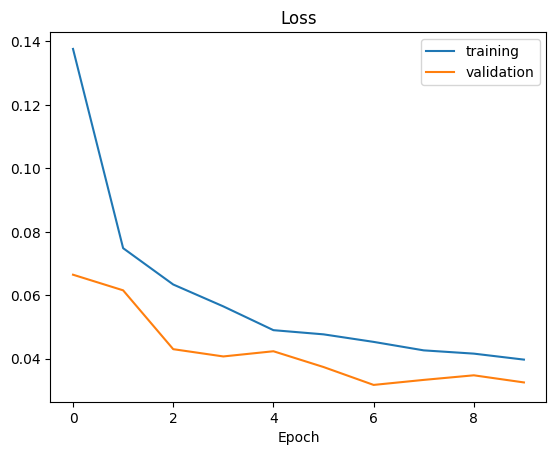

In [37]:

car = Car("track")



# Preprocess and get the data ready in this format (image_path, steering_angle)
img_path, steering = car.data_frame_preprocess()




# Now we split the data into train & test
X_train, X_valid, y_train, y_valid = train_test_split(img_path, steering, test_size=0.2, random_state=6)

print(len(X_train))



# call the NVIDIA model and initiate the architecture
model = car.nvidia_model()
print(model.summary())


# Now we train the model
history = model.fit_generator(car.batch_generator(X_train, y_train, 100, 1),
                                steps_per_epoch=300,
                                epochs=10,
                                validation_data=car.batch_generator(X_valid, y_valid, 100, 0),
                                validation_steps=200,
                                verbose=1,
                                shuffle=1)


# Plotting the loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')


# Save the model to disk to it use later
model.save('model.h5')
from google.colab import files
files.download('model.h5')
